In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=70

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8553 files belonging to 9 classes.


In [4]:
class_names = dataset.class_names
class_names

['Beans_angular_leaf_spot',
 'Healthy_Beans',
 'Healthy_Maize',
 'Maize_Blight',
 'Maize_Common_Rust',
 'Maize_Gray_Leaf_Spot',
 'Nkongwa_Leaves',
 'Nkongwa_Pests',
 'bean_rust']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[4 6 2 6 4 6 2 4 7 5 2 4 4 6 5 6 7 0 5 6 4 3 5 6 4 6 1 7 6 2 2 0]


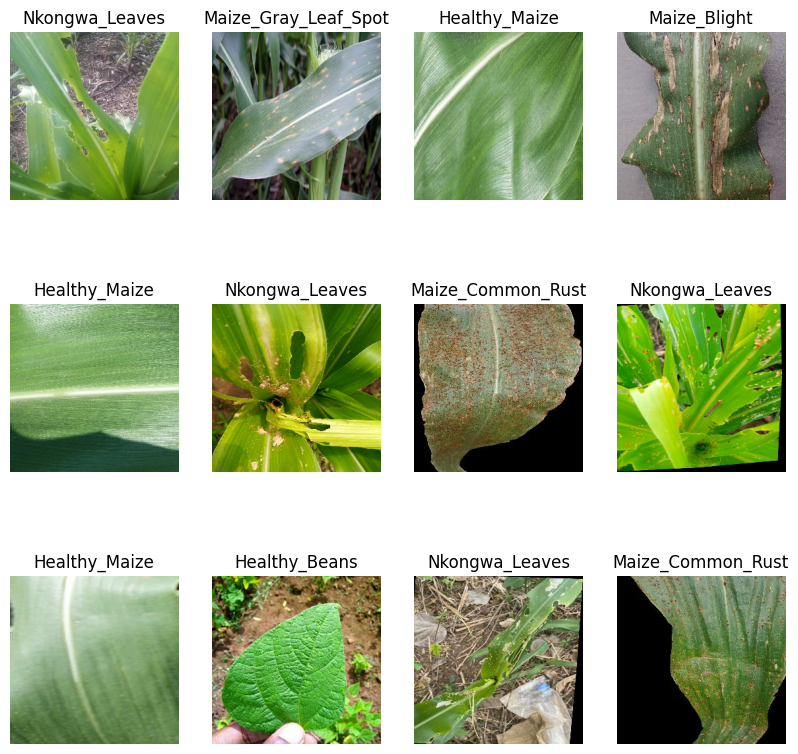

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

268

In [8]:
train_size = 0.8
len(dataset)*train_size

214.4

In [9]:
train_ds = dataset.take(214)
len(train_ds)

214

In [10]:
test_ds = dataset.skip(214)
len(test_ds)

54

In [11]:
val_size=0.1
len(dataset)*val_size

26.8

In [12]:
val_ds = test_ds.take(26)
len(val_ds)

26

In [13]:
test_ds = test_ds.skip(26)
len(test_ds)

28

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

214

In [17]:
len(val_ds)

26

In [18]:
len(test_ds)

28

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=70,
)


Epoch 1/70


214/214 [==============================] - 389s 2s/step - loss: 1.5407 - accuracy: 0.4452 - val_loss: 1.2722 - val_accuracy: 0.5300
Epoch 2/70
214/214 [==============================] - 309s 1s/step - loss: 1.0632 - accuracy: 0.6345 - val_loss: 0.8493 - val_accuracy: 0.7127
Epoch 3/70
214/214 [==============================] - 310s 1s/step - loss: 0.7670 - accuracy: 0.7190 - val_loss: 0.6799 - val_accuracy: 0.7200
Epoch 4/70
214/214 [==============================] - 305s 1s/step - loss: 0.6534 - accuracy: 0.7513 - val_loss: 0.6412 - val_accuracy: 0.7668
Epoch 5/70
214/214 [==============================] - 307s 1s/step - loss: 0.6005 - accuracy: 0.7684 - val_loss: 0.5866 - val_accuracy: 0.7668
Epoch 6/70
214/214 [==============================] - 310s 1s/step - loss: 0.5677 - accuracy: 0.7846 - val_loss: 0.5854 - val_accuracy: 0.7680
Epoch 7/70
214/214 [==============================] - 296s 1s/step - loss: 0.5321 - accuracy: 0.7940 - val_loss: 0.4906 - val_accuracy: 0.82

In [27]:
scores = model.evaluate(test_ds)

28/28 [==============================] - 130s 920ms/step - loss: 0.2320 - accuracy: 0.8873


In [28]:
scores

[0.23196837306022644, 0.8872767686843872]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 70, 'steps': 214}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

70

In [34]:
history.history['loss'][:5]

[1.540704607963562,
 1.063171148300171,
 0.7670058012008667,
 0.653416633605957,
 0.6004623770713806]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [36]:
val_acc

[0.5300480723381042,
 0.7127403616905212,
 0.7199519276618958,
 0.7668269276618958,
 0.7668269276618958,
 0.7680288553237915,
 0.8221153616905212,
 0.7884615659713745,
 0.7584134340286255,
 0.8461538553237915,
 0.8257211446762085,
 0.801682710647583,
 0.8377403616905212,
 0.8401442170143127,
 0.8293269276618958,
 0.8088942170143127,
 0.8040865659713745,
 0.8605769276618958,
 0.8665865659713745,
 0.8713942170143127,
 0.8762019276618958,
 0.859375,
 0.8665865659713745,
 0.8605769276618958,
 0.8665865659713745,
 0.8581730723381042,
 0.870192289352417,
 0.875,
 0.8653846383094788,
 0.879807710647583,
 0.870192289352417,
 0.8822115659713745,
 0.8689903616905212,
 0.8737980723381042,
 0.8894230723381042,
 0.8870192170143127,
 0.879807710647583,
 0.8870192170143127,
 0.9158653616905212,
 0.8786057829856873,
 0.901442289352417,
 0.870192289352417,
 0.9038461446762085,
 0.8846153616905212,
 0.9026442170143127,
 0.8822115659713745,
 0.901442289352417,
 0.8918269276618958,
 0.8930288553237915,
 0

In [37]:
acc

[0.44523948431015015,
 0.6344918012619019,
 0.7190420627593994,
 0.7513142228126526,
 0.7683995366096497,
 0.7846086621284485,
 0.7939544320106506,
 0.8091413378715515,
 0.8120619058609009,
 0.8138142228126526,
 0.8244742751121521,
 0.8294392228126526,
 0.8370327353477478,
 0.8436039686203003,
 0.8450642228126526,
 0.8472546935081482,
 0.8504672646522522,
 0.8541179895401001,
 0.8549941778182983,
 0.86200350522995,
 0.8647780418395996,
 0.8701810836791992,
 0.8714953064918518,
 0.86200350522995,
 0.87237149477005,
 0.876022219657898,
 0.8701810836791992,
 0.8795268535614014,
 0.8837617039680481,
 0.8809871673583984,
 0.8793808221817017,
 0.8830315470695496,
 0.8897488117218018,
 0.892231285572052,
 0.8901869058609009,
 0.8860981464385986,
 0.8967581987380981,
 0.9047897458076477,
 0.8973422646522522,
 0.9015771150588989,
 0.8958820104598999,
 0.9031834006309509,
 0.9033294320106506,
 0.9056658744812012,
 0.9039135575294495,
 0.9055198431015015,
 0.9066880941390991,
 0.905227780342102,


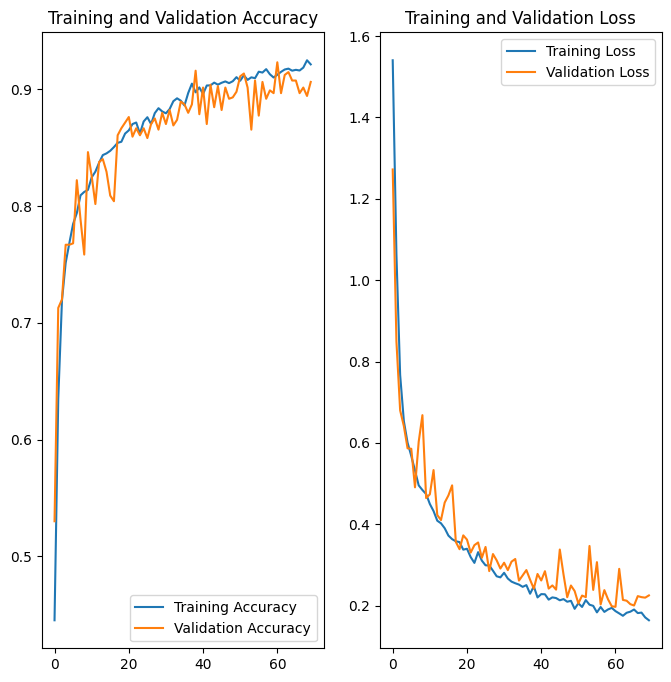

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Maize_Common_Rust
1/1 [==============================] - 3s 3s/step
predicted label: Maize_Common_Rust


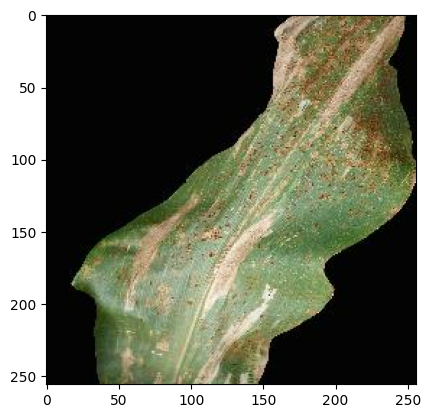

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 75ms/step


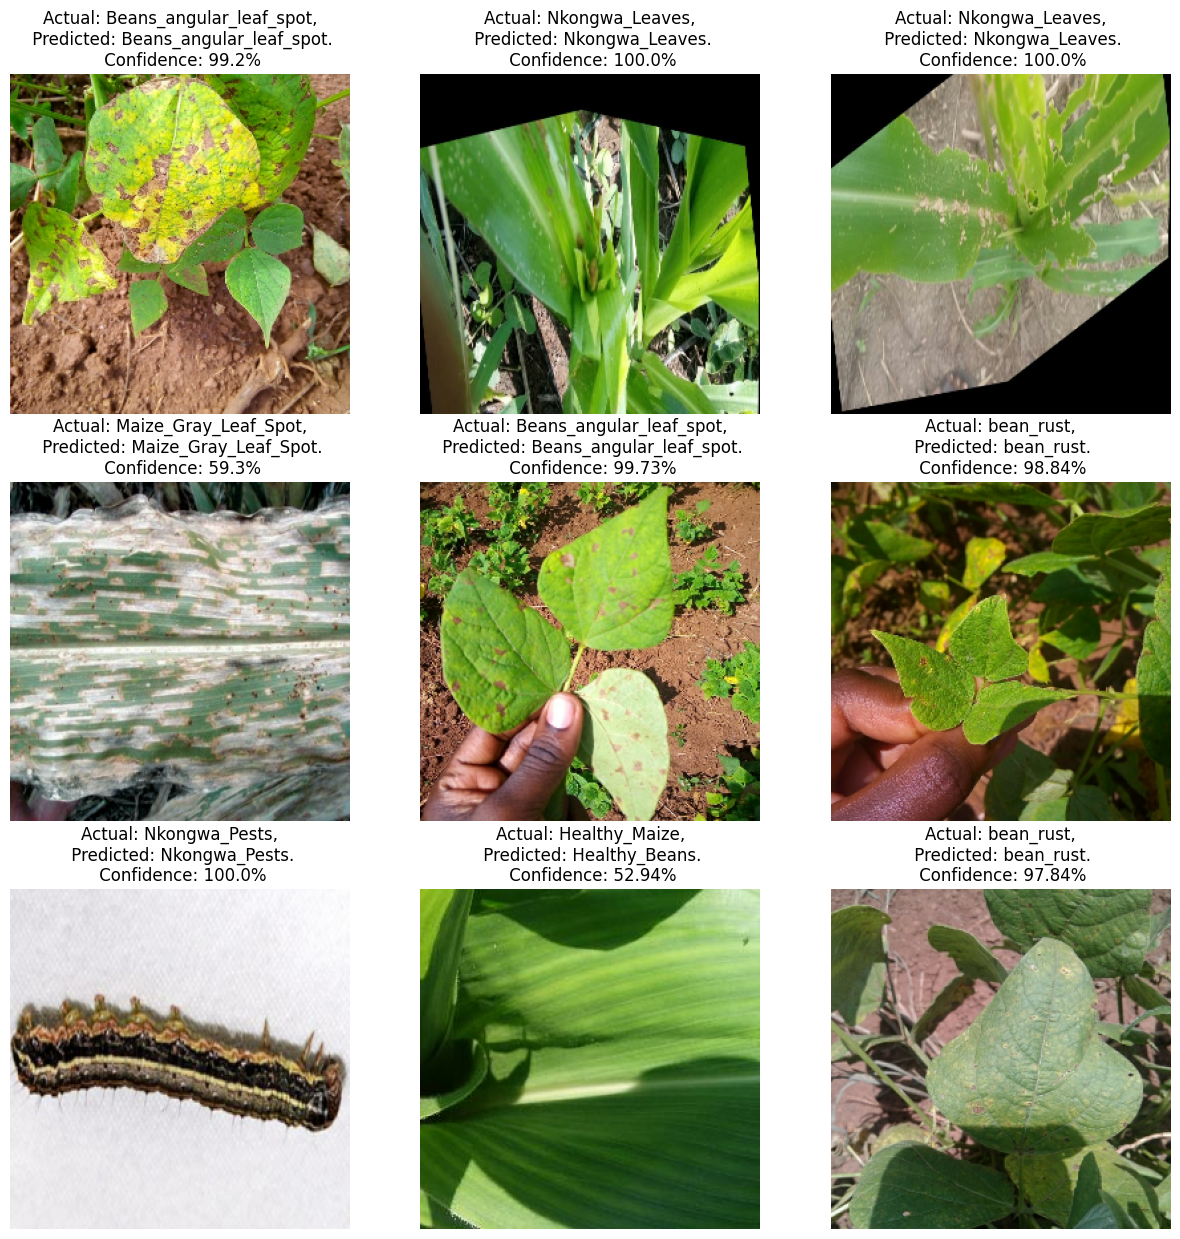

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [42]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/5\assets


INFO:tensorflow:Assets written to: ../saved_models/5\assets
